# **Machine Learning Notebook**

Submitted to [TakiWaehere - New Zealand Geospatial Hackathon 2021](https://www.mbie.govt.nz/science-and-technology/science-and-innovation/international-opportunities/new-zealand-r-d/innovative-partnerships/takiwaehere-the-geospatial-hackathon/)

by Ding

**Section 1 Import and Preprocess the Data**

Mount Google Drive and import the images and labels.

In [ ]:
from google.colab import drive

drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
from PIL import Image

image = Image.open('/gdrive/MyDrive/11FEB07222527-S3DS-013930604150_01_P003.TIF')
label = Image.open('/gdrive/MyDrive/first_label.tif')

In [ ]:
import numpy as np

image_array = np.array(image)
label_array = np.array(label)

The label is not necessarily colored. Make it gray.

In [ ]:
label_array = np.mean(label_array, axis=2)

Check the size of the image (and the label).

In [ ]:
print(image_array.shape)
print(label_array.shape)

(6506, 8025, 4)
(6506, 8025)


Cut the images and labels into 99 small pieces.

In [ ]:
M = image_array.shape[0]//8
N = image_array.shape[1]//10

images = [image_array[x:x+M,y:y+N] for x in range(0,image_array.shape[0],M) for y in range(0,image_array.shape[1],N)]
labels = [label_array[x:x+M,y:y+N] for x in range(0,label_array.shape[0],M) for y in range(0,label_array.shape[1],N)]

Display the upper left tiles.

In the label, the black areas show buildings while the yellow areas are non-buildings.

The upper left tile of the image:


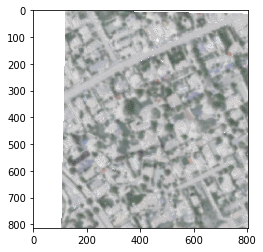

The upper left tile of the label:


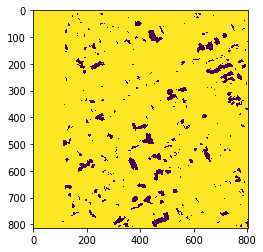

In [ ]:
from matplotlib import pyplot as plt

print('The upper left tile of the image:')
plt.imshow(images[0], interpolation='nearest')
plt.show()

print('The upper left tile of the label:')
plt.imshow(labels[0], interpolation='nearest')
plt.show()

Check the size of one tile.

In [ ]:
print(images[0].shape)
print(labels[0].shape)

(813, 802, 4)
(813, 802)


Drop the edge piles, i.e. keeping the 80 complete piles with a size of 813 x 802.

In [ ]:
images_selected = []
labels_selected = []

for i in range(len(images)):
  if images[i].shape == (813, 802, 4):
    images_selected.append(images[i])
    labels_selected.append(labels[i])

Resize the size to 512 * 512, which fits U-Net that will be used.

In [ ]:
import cv2

temp_images = []
temp_labels = []

for i in range(len(images_selected)):
  temp_images.append(cv2.resize(images_selected[i], dsize=(512, 512), interpolation=cv2.INTER_CUBIC))
  temp_labels.append(cv2.resize(np.uint8(labels_selected[i]), dsize=(512, 512), interpolation=cv2.INTER_CUBIC))

In [ ]:
resized_images = np.array(temp_images)
resized_labels = np.array(temp_labels)

resized_labels = resized_labels.reshape( * resized_labels.shape, 1)

In [ ]:
print(resized_images[0].shape)
print(resized_labels[0].shape)

(512, 512, 4)
(512, 512, 1)


Randomly split the data into a training set (70%), a validation set (10%) and a test set (20%).

In [ ]:
from sklearn.model_selection import train_test_split

image_train_data, image_test_data, label_train_data, label_test_data = train_test_split(resized_images, resized_labels, test_size=0.2, random_state=123)
image_train_data, image_val_data, label_train_data, label_val_data = train_test_split(image_train_data, label_train_data, test_size=0.125, random_state=123)

**Section 2 Transfer Learning from Pretrained Models**

Import the major PyTorch modules.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.utils as utils
import torchvision.datasets as dataset
import torchvision.transforms as transforms

Convert the lists into PyTorch tensors, which takes a while.

In [ ]:
image_train_data = torch.Tensor(image_train_data) 
label_train_data = torch.Tensor(label_train_data)

image_val_data = torch.Tensor(image_val_data) 
label_val_data = torch.Tensor(label_val_data)

image_test_data = torch.Tensor(image_test_data) 
label_test_data = torch.Tensor(label_test_data)

Don't forget to switch the channel positions.

In [ ]:
image_train_data = image_train_data.permute(0, 3, 1, 2)
label_train_data = label_train_data.permute(0, 3, 1, 2)

image_val_data = image_val_data.permute(0, 3, 1, 2)
label_val_data = label_val_data.permute(0, 3, 1, 2)

image_test_data = image_test_data.permute(0, 3, 1, 2)
label_test_data = label_test_data.permute(0, 3, 1, 2)

Check the shape of the data.

In [ ]:
image_train_data.shape

torch.Size([56, 4, 512, 512])

Combine images and labels and create PyTorch dataloaders.

In [ ]:
train_dataset = torch.utils.data.TensorDataset(image_train_data, label_train_data)
val_dataset = torch.utils.data.TensorDataset(image_val_data, label_val_data)
test_dataset = torch.utils.data.TensorDataset(image_test_data, label_test_data)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, num_workers=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, num_workers=2, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, num_workers=2, shuffle=True)

We adopt a pretrained neural network, U-Net.

The U-Net is avaiable in [this GitHub repo](https://github.com/MrGiovanni/ModelsGenesis).

Clone the repo.

In [ ]:
!git clone https://github.com/MrGiovanni/ModelsGenesis.git

fatal: destination path 'ModelsGenesis' already exists and is not an empty directory.


Modify and run [unet.py](https://github.com/greed2411/unet_pytorch/blob/master/unet.py) that contains a U-Net architecture.

In [ ]:
class ContBatchNorm2d(nn.modules.batchnorm._BatchNorm):
    def _check_input_dim(self, input):

        if input.dim() != 4:
            raise ValueError('expected 4D input (got {}D input)'.format(input.dim()))

    def forward(self, input):
        self._check_input_dim(input)
        return F.batch_norm(
            input, self.running_mean, self.running_var, self.weight, self.bias,
            True, self.momentum, self.eps)

class LUConv(nn.Module):
    def __init__(self, in_chan, out_chan, act):
        super(LUConv, self).__init__()
        self.conv1 = nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1)
        self.bn1 = ContBatchNorm2d(out_chan)

        if act == 'relu':
            self.activation = nn.ReLU(out_chan)
        elif act == 'prelu':
            self.activation = nn.PReLU(out_chan)
        elif act == 'elu':
            self.activation = nn.ELU(inplace=True)
        else:
            raise

    def forward(self, x):
        out = self.activation(self.bn1(self.conv1(x)))
        return out

def _make_nConv(in_channel, depth, act, double_chnnel=False):
    if double_chnnel:
        layer1 = LUConv(in_channel, 32 * (2 ** (depth+1)),act)
        layer2 = LUConv(32 * (2 ** (depth+1)), 32 * (2 ** (depth+1)),act)
    else:
        layer1 = LUConv(in_channel, 32*(2**depth),act)
        layer2 = LUConv(32*(2**depth), 32*(2**depth)*2,act)

    return nn.Sequential(layer1,layer2)

class DownTransition(nn.Module):
    def __init__(self, in_channel,depth, act):
        super(DownTransition, self).__init__()
        self.ops = _make_nConv(in_channel, depth,act)
        self.maxpool = nn.MaxPool2d(2)
        self.current_depth = depth

    def forward(self, x):
        if self.current_depth == 3:
            out = self.ops(x)
            out_before_pool = out
        else:
            out_before_pool = self.ops(x)
            out = self.maxpool(out_before_pool)
        return out, out_before_pool

class UpTransition(nn.Module):
    def __init__(self, inChans, outChans, depth,act):
        super(UpTransition, self).__init__()
        self.depth = depth
        self.up_conv = nn.ConvTranspose2d(inChans, outChans, kernel_size=2, stride=2)
        self.ops = _make_nConv(inChans+ outChans//2,depth, act, double_chnnel=True)

    def forward(self, x, skip_x):
        out_up_conv = self.up_conv(x)
        concat = torch.cat((out_up_conv,skip_x),1)
        out = self.ops(concat)
        return out

class OutputTransition(nn.Module):
    def __init__(self, inChans, n_labels):

        super(OutputTransition, self).__init__()
        self.final_conv = nn.Conv2d(inChans, n_labels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.sigmoid(self.final_conv(x))
        return out

class UNet2D(nn.Module):
    def __init__(self, n_class=1, act='relu'):
        super(UNet2D, self).__init__()

        self.down_tr64 = DownTransition(4,0,act)
        self.down_tr128 = DownTransition(64,1,act)
        self.down_tr256 = DownTransition(128,2,act)
        self.down_tr512 = DownTransition(256,3,act)

        self.up_tr256 = UpTransition(512,512,2,act)
        self.up_tr128 = UpTransition(256,256,1,act)
        self.up_tr64 = UpTransition(128,128,0,act)
        self.out_tr = OutputTransition(64,n_class)

    def forward(self, x):
        self.out64, self.skip_out64 = self.down_tr64(x)
        self.out128,self.skip_out128 = self.down_tr128(self.out64)
        self.out256,self.skip_out256 = self.down_tr256(self.out128)
        self.out512,self.skip_out512 = self.down_tr512(self.out256)

        self.out_up_256 = self.up_tr256(self.out512,self.skip_out256)
        self.out_up_128 = self.up_tr128(self.out_up_256,self.skip_out128)
        self.out_up_64 = self.up_tr64(self.out_up_128,self.skip_out64)
        self.out = self.out_tr(self.out_up_64)

        return self.out

In [ ]:
model = UNet2D()

Define a loss function.

In [ ]:
def dice_loss(inputs, target):
    num = target.size(0)
    inputs = inputs.reshape(num, -1)
    target = target.reshape(num, -1)
    smooth = 1.0
    intersection = (inputs * target)
    dice = (2. * intersection.sum(1) + smooth) / (inputs.sum(1) + target.sum(1) + smooth)
    dice = 1 - dice.sum() / num
    return dice

def bce_dice_loss(inputs, target):
    dicescore = dice_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)
    return bceloss + dicescore

In [ ]:
criterion = bce_dice_loss

Select an optimizer. Fine-tune the hyperparameters.

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), 0.00002)

In [ ]:
from torch.optim import lr_scheduler 

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=1)

Have a look at the architecture of U-Net.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

UNet2D(
  (down_tr64): DownTransition(
    (ops): Sequential(
      (0): LUConv(
        (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): ContBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
      (1): LUConv(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): ContBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
    )
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_tr128): DownTransition(
    (ops): Sequential(
      (0): LUConv(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): ContBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
      (1): LUConv(
        (conv1)

In [ ]:
loss_history = []
loss_history_val = []

In [ ]:
best_loss_val = float('inf')

Start training!

The network is deep enough, so there is no need to train for many epoches, which may potentially cause overfitting and costs more time.

In [ ]:
print('Start training.')
for epoch in range(3):

    model.train()
    loss_running = []
    for _, (x,y) in enumerate(train_dataloader):
        x, y = x.float().to(device), y.float().to(device)
        
        pred = model(x)
        loss = criterion(pred, y)
        loss_running.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
       
    loss_history.append(np.mean(loss_running))

    model.eval()
    with torch.no_grad():
        loss_val_running = []
        for _, (x_val, y_val) in enumerate(val_dataloader):
            x_val, y_val = x_val.to(device), y_val.to(device)
            pred_val = model.forward(x_val) #pred_val = model(x_val)
            loss_val= criterion(pred_val, y_val)
            loss_val_running.append(loss_val.item())
    
    curr_loss_val = np.mean(loss_val_running)
    loss_history_val.append(curr_loss_val)

    if curr_loss_val < best_loss_val:
        best_loss_val = curr_loss_val
        torch.save(model.state_dict(), '/gdrive/My Drive/best_model.pth')

    scheduler.step()

    print('epoch', epoch, 'train loss', loss_history[-1], 'val loss', loss_history_val[-1])

Start training.
epoch 0 train loss -144.05135454450334 val loss -168.61473083496094
epoch 1 train loss -183.54214368547713 val loss -210.73074340820312
epoch 2 train loss -215.31128692626953 val loss -232.84410095214844


Use the remaining 20% of the data to test our model.

In [ ]:
def plot_label(label_2d_array, axx):
  label_cpu = label_2d_array.cpu().detach().numpy()
  reshaped_label_cpu = np.reshape(label_cpu,(512, 512))
  print(np.max(reshaped_label_cpu), np.min(reshaped_label_cpu))
  reshaped_label_cpu_bin = np.round(reshaped_label_cpu)
  axx.imshow(reshaped_label_cpu_bin)

Visualize a few piles in the test data.

The first line of graphs are the predicted labels by the model.

The second line of graphs are the labels by ENVI.

0.98933524 0.0012141065
255.0 0.0
0.98642194 0.0037185543
255.0 0.0
0.9282281 0.002703497
255.0 0.0
0.9754724 0.0017417811
255.0 0.0


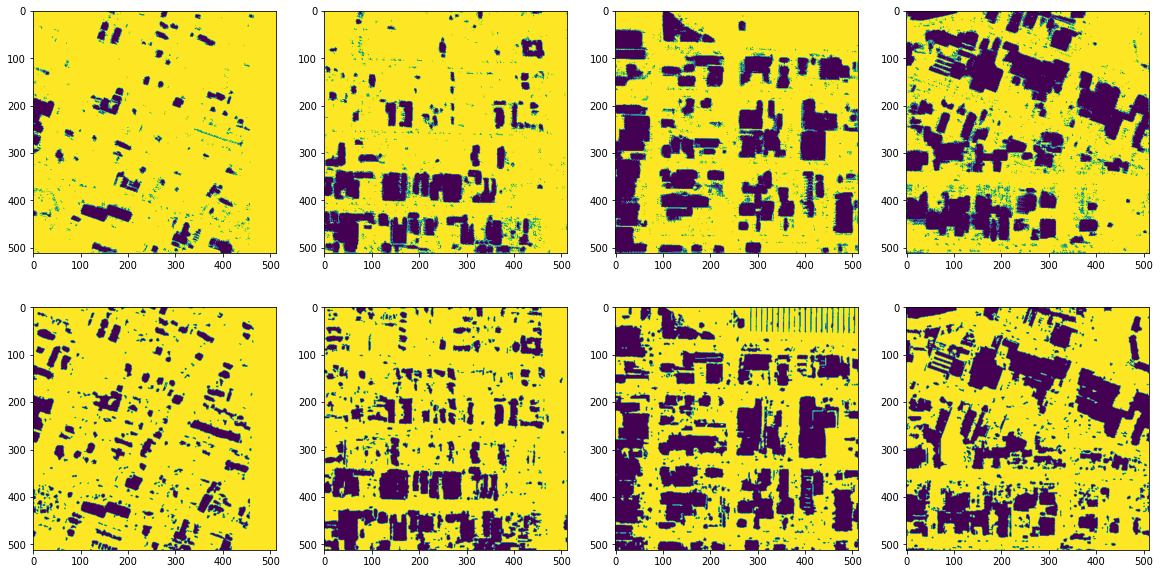

In [ ]:
import random

dataloader = test_dataloader
ncol = 4
rand_ndx = random.sample(range(0, len(dataloader)), ncol)
fig, ax = plt.subplots(nrows=2, ncols=ncol, figsize=(20, 10))
i = 0
for n, (x, y) in enumerate(dataloader):
  x, y = x.to(device), y.to(device)
  if n in rand_ndx:
    pred = model.forward(x)
    plot_label(pred[0,0,:,:], ax[0][i])
    plot_label(y[0,0,:,:], ax[1][i])
    i += 1

**Section 3 Test and Output the Results**

Let us try different maps at other time.

In [ ]:
image_1 = Image.open('/gdrive/MyDrive/11FEB07222527-S3DS-013930604150_01_P003.TIF')
image_2 = Image.open('/gdrive/MyDrive/12JUN12221244-S3DS-013930604150_01_P001.TIF')
image_3 = Image.open('/gdrive/MyDrive/12OCT30221304-S3DS-013930604150_01_P004.TIF')
image_4 = Image.open('/gdrive/MyDrive/13MAR22222157-S3DS-013930604150_01_P002.TIF')

In [ ]:
image_1_array = np.array(image_1)
image_2_array = np.array(image_2)
image_3_array = np.array(image_3)
image_4_array = np.array(image_4)

images_array = (image_1_array, image_2_array, image_3_array, image_4_array)
images_array = np.array(images_array)

In [ ]:
images_array.shape

(4, 6506, 8025, 4)

In [ ]:
temp_images = []

for i in range(len(images_array)):
  temp_images.append(cv2.resize(images_array[i], dsize=(512, 512), interpolation=cv2.INTER_CUBIC))

In [ ]:
temp_images = np.array(temp_images)

temp_images = np.moveaxis(temp_images, -1, 1)

temp_images.shape

(4, 4, 512, 512)

In [ ]:
images_test_data = torch.Tensor(temp_images)

In [ ]:
test_dataloader = torch.utils.data.DataLoader(images_test_data, batch_size=1, num_workers=1, shuffle=False)

Plot the predicted bulding labels for February 2011, June 2012, October 2012 and March 2013.

0.9746617 0.0008533193
0.9758531 0.00061076606
0.976429 0.0013601187
0.9821293 0.0016582806


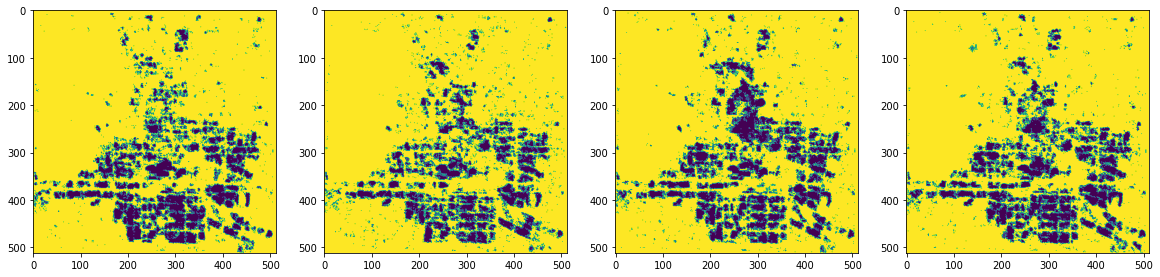

In [ ]:
chch = []

dataloader = test_dataloader
ncol = 4
rand_ndx = random.sample(range(0, len(dataloader)), ncol)
fig, ax = plt.subplots(nrows=1, ncols=ncol, figsize=(20, 10))
i = 0
for n, x in enumerate(dataloader):
  x = x.to(device)
  if n in rand_ndx:
    pred = model.forward(x)
    plot_label(pred[0,0,:,:], ax[i])
    with torch.no_grad():
      chch.append(pred.cpu().numpy())
    i += 1

Compare the differences between February 2011 and June 2012, and June 2012 and March 2013.

Map in June 2012, blue areas are the differences.


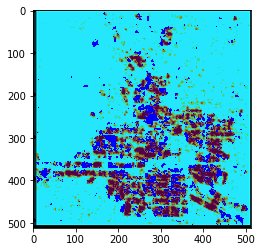

Map in March 2013, blue areas are the differences.


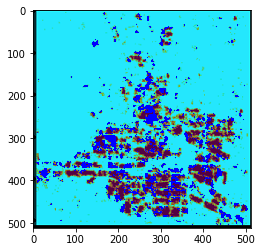

Differences


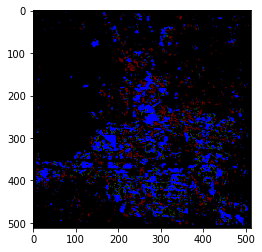

True

In [ ]:
image1 = cv2.imread("chch_2012_6.png")
image2 = cv2.imread("chch_2013_3.png")

difference = cv2.subtract(image1, image2)

Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
difference[mask != 255] = [0, 0, 255]

image1[mask != 255] = [0, 0, 255]
image2[mask != 255] = [0, 0, 255]

print('Map in June 2012, blue areas are the differences.')
plt.imshow(image1, interpolation='nearest')
plt.show()

print('Map in March 2013, blue areas are the differences.')
plt.imshow(image2, interpolation='nearest')
plt.show()

print('Differences')
plt.imshow(difference, interpolation='nearest')
plt.show()

cv2.imwrite('diffOverImage1.png', image1)
cv2.imwrite('diffOverImage2.png', image2)
cv2.imwrite('diff.png', difference)

This time we only work on a small pile of the images.

We locate a place with significant changes before and after the earthquake.

Repeat the steps.

(519, 519, 3)
0.98318934 0.0059862174
0.9298938 0.003780171
0.9934509 0.0052301213
0.9887761 0.0042868704


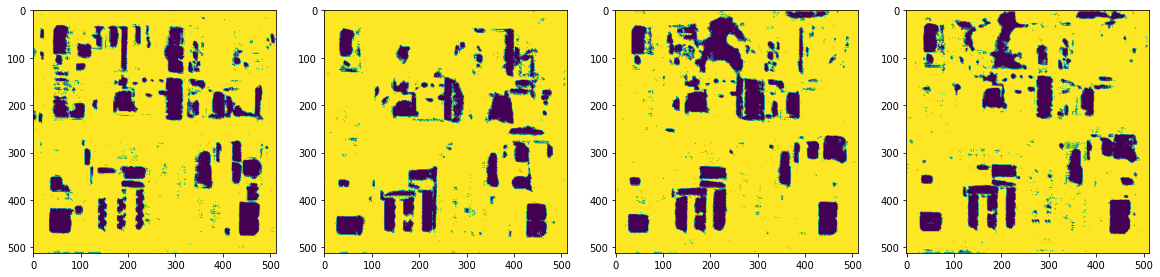

In [ ]:
image_1 = Image.open('/gdrive/MyDrive/cut_11FEB07222527-S3DS-013930604150_01_P003.tif')
image_2 = Image.open('/gdrive/MyDrive/cut_12JUN12221244-S3DS-013930604150_01_P001.tif')
image_3 = Image.open('/gdrive/MyDrive/cut_12OCT30221304-S3DS-013930604150_01_P004.tif')
image_4 = Image.open('/gdrive/MyDrive/cut_13MAR22222157-S3DS-013930604150_01_P002.tif')

image_1_array = np.array(image_1)
image_2_array = np.array(image_2)
image_3_array = np.array(image_3)
image_4_array = np.array(image_4)

print(image_1_array.shape)

image_1_array = np.concatenate((image_1_array, np.zeros((519, 519, 1))), axis=2)
image_2_array = np.concatenate((image_2_array, np.zeros((519, 519, 1))), axis=2)
image_3_array = np.concatenate((image_3_array, np.zeros((519, 519, 1))), axis=2)
image_4_array = np.concatenate((image_4_array, np.zeros((519, 519, 1))), axis=2)

images_array = (image_1_array, image_2_array, image_3_array, image_4_array)
images_array = np.array(images_array)

temp_images = []

for i in range(len(images_array)):
  temp_images.append(cv2.resize(images_array[i], dsize=(512, 512), interpolation=cv2.INTER_CUBIC))

temp_images = np.array(temp_images)

temp_images = np.moveaxis(temp_images, -1, 1)

images_test_data = torch.Tensor(temp_images)

test_dataloader = torch.utils.data.DataLoader(images_test_data, batch_size=1, num_workers=1, shuffle=False)

chch = []

dataloader = test_dataloader
ncol = 4
rand_ndx = random.sample(range(0, len(dataloader)), ncol)
fig, ax = plt.subplots(nrows=1, ncols=ncol, figsize=(20, 10))
i = 0
for n, x in enumerate(dataloader):
  x = x.to(device)
  if n in rand_ndx:
    pred = model.forward(x)
    plot_label(pred[0,0,:,:], ax[i])
    with torch.no_grad():
      chch.append(pred.cpu().numpy())
    i += 1

We can obervse that from February 2011 to June 2012, the amount of buildings decreased (because of the earthquake), and from June 2012 to March 2013, the amount of buildings increased (because of the rebuilding). Some working sites were misclassified as buildings.

A small map in June 2012, blue areas are the differences.


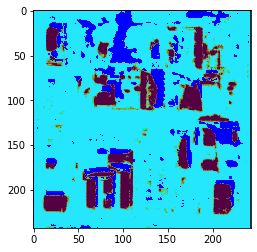

A small map in March 2013, blue areas are the differences.


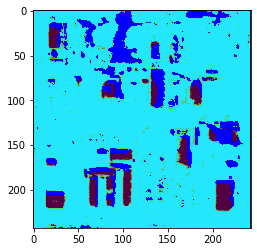

Differences


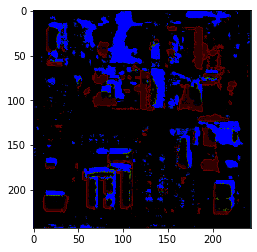

True

In [ ]:
image1 = cv2.imread("chch_2012_6_small.png")
image2 = cv2.imread("chch_2013_3_small.png")

difference = cv2.subtract(image1, image2)

Conv_hsv_Gray = cv2.cvtColor(difference, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(Conv_hsv_Gray, 0, 255,cv2.THRESH_BINARY_INV |cv2.THRESH_OTSU)
difference[mask != 255] = [0, 0, 255]

image1[mask != 255] = [0, 0, 255]
image2[mask != 255] = [0, 0, 255]

print('A small map in June 2012, blue areas are the differences.')
plt.imshow(image1, interpolation='nearest')
plt.show()

print('A small map in March 2013, blue areas are the differences.')
plt.imshow(image2, interpolation='nearest')
plt.show()

print('Differences')
plt.imshow(difference, interpolation='nearest')
plt.show()

cv2.imwrite('diffOverImage1.png', image1)
cv2.imwrite('diffOverImage2.png', image2)
cv2.imwrite('diff.png', difference)